In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [101]:
df = pd.read_csv( './train_preprocessed.csv' )

In [102]:
# Create a validation set, with last 20% of data
num_val = int( len(df) * 0.2 )

ylog = np.log1p( df['price_doc'].values )
df.drop( ['price_doc'], axis = 1, inplace = True )
X = df.values
X_train = X[ :-num_val ]
X_val = X[ -num_val: ]
ylog_train = ylog[ :-num_val ]
ylog_val = ylog[ -num_val: ]

print('X shape is', X.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)

('X shape is', (30471L, 312L))
('X_train shape is', (24377L, 312L))
('y_train shape is', (24377L,))
('X_val shape is', (6094L, 312L))
('y_val shape is', (6094L,))


In [103]:
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df.columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df.columns)

In [104]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[ (dtrain, 'train'), (dval, 'val') ],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	train-rmse:14.3405	val-rmse:14.4764
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 20 rounds.
[20]	train-rmse:5.16445	val-rmse:5.2736
[40]	train-rmse:1.90601	val-rmse:1.99391
[60]	train-rmse:0.809544	val-rmse:0.868502
[80]	train-rmse:0.514103	val-rmse:0.533786
[100]	train-rmse:0.455936	val-rmse:0.454069
[120]	train-rmse:0.441796	val-rmse:0.435285
[140]	train-rmse:0.434735	val-rmse:0.428075
[160]	train-rmse:0.429767	val-rmse:0.425206
[180]	train-rmse:0.424995	val-rmse:0.424541
[200]	train-rmse:0.419906	val-rmse:0.423723
[220]	train-rmse:0.415975	val-rmse:0.423087
[240]	train-rmse:0.41203	val-rmse:0.423418
Stopping. Best iteration:
[225]	train-rmse:0.414892	val-rmse:0.423064



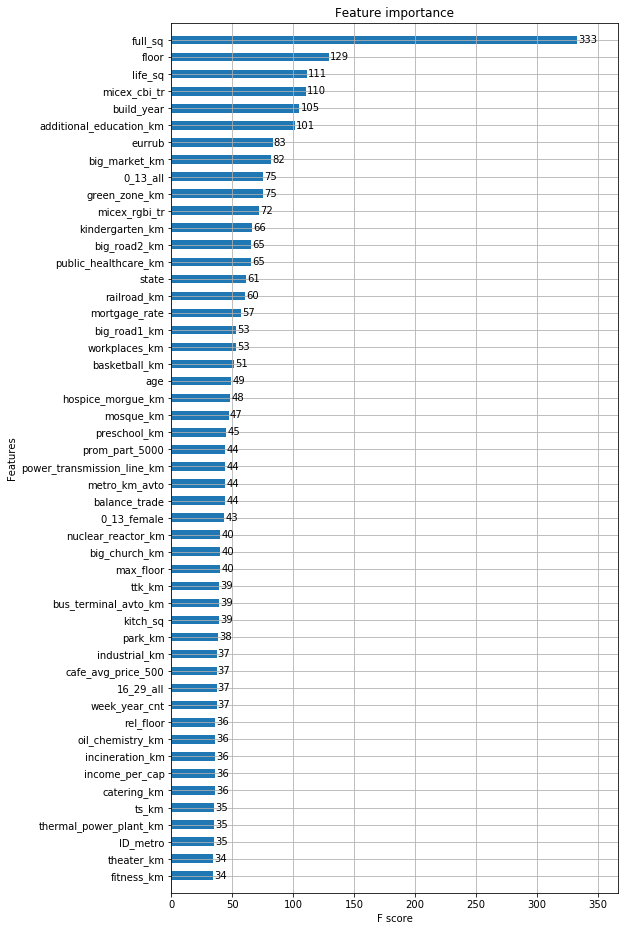

In [105]:
# Строим диаграмму важности признаков
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance( partial_model, height=0.5, ax=ax, max_num_features = 50 )

In [109]:
# Сохраняем файл с ошибками классификатора на валидирующей выборке.

# Признаки берем только наиболее значимые.
f_score = partial_model.get_fscore()
most_important_features = list( sorted( f_score, key = lambda x: f_score[x], reverse = True ) )[:50]
top_errors = df[ most_important_features ]
top_errors = top_errors[ -num_val: ]
top_errors['log_price'] = ylog_val
top_errors['predicted_log_price'] = partial_model.predict( dval )
top_errors['price'] = np.exp( top_errors.log_price ) - 1
top_errors['predicted_price'] = np.exp( top_errors.predicted_log_price ) - 1
top_errors['price_per_sqm'] = top_errors.price / top_errors.full_sq
top_errors['squared_error'] = ( top_errors.log_price - top_errors.predicted_log_price )**2
top_errors.sort_values( 'squared_error', ascending = False, inplace = True )
top_errors.to_excel( './top_errors.xls', index = True )

In [34]:
# Обучаемся на всей выборке.
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), 
                  xgb.DMatrix(X, ylog, feature_names=df.columns), 
                  num_boost_round = num_boost_round)

In [35]:
# Сохраняем модель
model.save_model( './model' )